# Fetch results 

In [11]:
options(warn=-1)

In [12]:
library_load <- suppressMessages(
    
    suppressWarnings(
        
        list(
        
            # Seurat 
            library(Seurat), 
            library(SeuratWrappers), 

            # Data 
            library(tidyverse), 
            library(data.table), 

            # miloR
            library(miloR), 
            library(ggbeeswarm), 

            # Plotting 
            library(ggplot2), 
            library(patchwork), 
            library(cowplot), 

            # Pyhton compatibility
            library(reticulate)

        )
    )
)

In [13]:
# Configure reticulate 
use_condaenv(condaenv="pyscenic.0.12.1", conda="/nobackup/peer/fdeckert/miniconda3/bin/conda", required=NULL)
py_config()

python:         /nobackup/peer/fdeckert/miniconda3/envs/pyscenic.0.12.1/bin/python
libpython:      /nobackup/peer/fdeckert/miniconda3/envs/pyscenic.0.12.1/lib/libpython3.9.so
pythonhome:     /nobackup/peer/fdeckert/miniconda3/envs/pyscenic.0.12.1:/nobackup/peer/fdeckert/miniconda3/envs/pyscenic.0.12.1
version:        3.9.21 | packaged by conda-forge | (main, Dec  5 2024, 13:51:40)  [GCC 13.3.0]
numpy:          /nobackup/peer/fdeckert/miniconda3/envs/pyscenic.0.12.1/lib/python3.9/site-packages/numpy
numpy_version:  1.23.5

NOTE: Python version was forced by use_python() function

In [14]:
random_seed <- 42
set.seed(random_seed)

In [15]:
# Set working directory to project root
setwd("/research/peer/fdeckert/FD20200109SPLENO")

In [16]:
# Plotting Theme
source("plotting_global.R")
ggplot2::theme_set(theme_global_set(size_select=1)) # From project global source()

In [17]:
# Helper functions
source("bin/so_pl.R")

# Import data 

In [18]:
# Seurat object 
so <- readRDS("data/scRNAseq/object/pp.rds")

In [19]:
# AUC mtx from individual grn 
auc_mtx_0 <- read.csv("result/scenic/scRNAseq/res_0/auc_mtx.csv", row.names=1) %>% t()
rownames(auc_mtx_0) <- gsub("\\.", "", rownames(auc_mtx_0))

auc_mtx_1 <- read.csv("result/scenic/scRNAseq/res_1/auc_mtx.csv", row.names=1) %>% t()
rownames(auc_mtx_1) <- gsub("\\.", "", rownames(auc_mtx_1))

auc_mtx_2 <- read.csv("result/scenic/scRNAseq/res_2/auc_mtx.csv", row.names=1) %>% t()
rownames(auc_mtx_2) <- gsub("\\.", "", rownames(auc_mtx_2))

auc_mtx_3 <- read.csv("result/scenic/scRNAseq/res_3/auc_mtx.csv", row.names=1) %>% t()
rownames(auc_mtx_3) <- gsub("\\.", "", rownames(auc_mtx_3))

In [20]:
# Attach AUC to Seurat 
so_0 <- subset(so, subset=cell_id %in% colnames(auc_mtx_0))
auc_mtx_0 <- auc_mtx_0[, colnames(so_0)]
so_0[["AUC"]] <- CreateAssayObject(data=auc_mtx_0[, colnames(so_0)], min.cells=0, min.features=0)

so_1 <- subset(so, subset=cell_id %in% colnames(auc_mtx_1))
auc_mtx_1 <- auc_mtx_1[, colnames(so_1)]
so_1[["AUC"]] <- CreateAssayObject(data=auc_mtx_1[, colnames(so_1)], min.cells=0, min.features=0)

so_2 <- subset(so, subset=cell_id %in% colnames(auc_mtx_2))
auc_mtx_2 <- auc_mtx_2[, colnames(so_2)]
so_2[["AUC"]] <- CreateAssayObject(data=auc_mtx_2[, colnames(so_2)], min.cells=0, min.features=0)

so_3 <- subset(so, subset=cell_id %in% colnames(auc_mtx_3))
auc_mtx_3 <- auc_mtx_3[, colnames(so_3)]
so_3[["AUC"]] <- CreateAssayObject(data=auc_mtx_3[, colnames(so_3)], min.cells=0, min.features=0)

# RSS 

In [21]:
meta <- so@meta.data

In [22]:
# Load python libraries
pysenic_rss <- import("pyscenic.rss", convert=FALSE)
pd <- import("pandas", convert=FALSE)

In [23]:
rss_get <- function(meta, auc_mtx, sample_group) {
    
    # Load python libraries
    pysenic_rss <- import("pyscenic.rss", convert=FALSE)
    pd <- import("pandas", convert=FALSE)

    # Get meta subset
    meta <- meta[meta$sample_group==sample_group, ]

    # Get AUC matx 
    auc_mtx <- auc_mtx[, rownames(meta)] %>% t() %>% as.data.frame()

    # Get regulon specific scores 
    rss <- pysenic_rss$regulon_specificity_scores(auc_mtx, pd$Series(r_to_py(meta$celltype_low))) %>% py_to_r()

    # Get matrix
    mat <- tibble::rownames_to_column(rss, "celltype_low") %>% 
        reshape2::melt(., id.vars=c("celltype_low"), variable.name="module", value.name="rss") %>% 
        dplyr::arrange(celltype_low, desc(rss)) %>% 
        dplyr::group_by(celltype_low) %>%
        dplyr::mutate(rank=1:n()) %>% 
        dplyr::mutate(label_rank=ifelse(rank %in% 1:20, as.character(module), NA)) %>% 
        dplyr::mutate(sample_group=sample_group)

    return(mat)
    
}

In [24]:
rss_plot <- function(mat, title=NULL) {

    mat$celltype_low <- factor(mat$celltype_low, levels=names(color$celltype_low))

    dp_rss_top_label <- ggplot(mat, aes(x=rank, y=rss, label=label_rank, color=celltype_low)) + 
        geom_point(size=1) + 
        xlab("") + ylab("RSS") + ggtitle(title) + 
        ylim(0, 1) + 
        facet_grid(~celltype_low, scales="free_y") +
        scale_color_manual(values=color$celltype_low, name="Cell type") + 
        scale_x_continuous(breaks=seq(0, floor(max(mat_1$rank)/100)*100, 100), labels=seq(0, floor(max(mat$rank)/100)*100, 100)) + 
        ggrepel::geom_text_repel(segment.color="black", force=10, force_pull=1, max.overlaps=getOption("ggrepel.max.overlaps", default=100), size=5, alpha=1, guide="none", segment.size=0.05, color="black", min.segment.length=0) + 
        guides(color=guide_legend(ncol=1, override.aes=list(alpha=1, size=1.5), keywidth=0, keyheight=0.25, default.unit="cm")) + 
        facet_wrap(~celltype_low, nrow=1) + 
        theme(legend.position="none")

    return(dp_rss_top_label)
    
}

In [25]:
mat_1 <- rss_get(so_0@meta.data, auc_mtx_0, "Bl6_NaCl_D6")
mat_2 <- rss_get(so_0@meta.data, auc_mtx_0, "Bl6_CpG_D6")

mat_3 <- rss_get(so_1@meta.data, auc_mtx_1, "IFNAR_fl_Baseline_D0")
mat_4 <- rss_get(so_1@meta.data, auc_mtx_1, "IFNAR_fl_CpG_D1")
mat_5 <- rss_get(so_1@meta.data, auc_mtx_1, "IFNAR_fl_CpG_D3")
mat_6 <- rss_get(so_1@meta.data, auc_mtx_1, "IFNAR_fl_LysM_cre_Baseline_D0")
mat_7 <- rss_get(so_1@meta.data, auc_mtx_1, "IFNAR_fl_LysM_cre_CpG_D1")
mat_8 <- rss_get(so_1@meta.data, auc_mtx_1, "IFNAR_fl_LysM_cre_CpG_D3")

mat_9 <- rss_get(so_2@meta.data, auc_mtx_2, "Bl6_NaCl_D6")
mat_10 <- rss_get(so_2@meta.data, auc_mtx_2, "Bl6_CpG_D6")

mat_11 <- rss_get(so_3@meta.data, auc_mtx_3, "IFNAR_fl_Baseline_D0")
mat_12 <- rss_get(so_3@meta.data, auc_mtx_3, "IFNAR_fl_CpG_D1")
mat_13 <- rss_get(so_3@meta.data, auc_mtx_3, "IFNAR_fl_CpG_D3")
mat_14 <- rss_get(so_3@meta.data, auc_mtx_3, "IFNAR_fl_LysM_cre_Baseline_D0")
mat_15 <- rss_get(so_3@meta.data, auc_mtx_3, "IFNAR_fl_LysM_cre_CpG_D1")
mat_16 <- rss_get(so_3@meta.data, auc_mtx_3, "IFNAR_fl_LysM_cre_CpG_D3")

In [26]:
saveRDS(
    
    list(
    
        Bl6_NaCl_D6_Ery_BSF=mat_1, 
        Bl6_CpG_D6_Ery_BSF=mat_2,

        IFNAR_fl_Baseline_D0_Ery_VBC=mat_3,
        IFNAR_fl_CpG_D1_Ery_VBC=mat_4,
        IFNAR_fl_CpG_D3_Ery_VBC=mat_5,
        IFNAR_fl_LysM_cre_Baseline_D0_Ery_VBC=mat_6,
        IFNAR_fl_LysM_cre_CpG_D1_Ery_VBC=mat_7,
        IFNAR_fl_LysM_cre_CpG_D3_Ery_VBC=mat_8,

        Bl6_NaCl_D6_MoRPM_BSF=mat_9, 
        Bl6_CpG_D6_MoRPM_BSF=mat_10,

        IFNAR_fl_Baseline_D0_MoRPM_VBC=mat_11,
        IFNAR_fl_CpG_D1_MoRPM_VBC=mat_12,
        IFNAR_fl_CpG_D3_MoRPM_VBC=mat_13,
        IFNAR_fl_LysM_cre_Baseline_D0_MoRPM_VBC=mat_14,
        IFNAR_fl_LysM_cre_CpG_D1_MoRPM_VBC=mat_15,
        IFNAR_fl_LysM_cre_CpG_D3_MoRPM_VBC=mat_16
    ), 
    
    "data/scRNAseq/scenic/rss.rds"

)

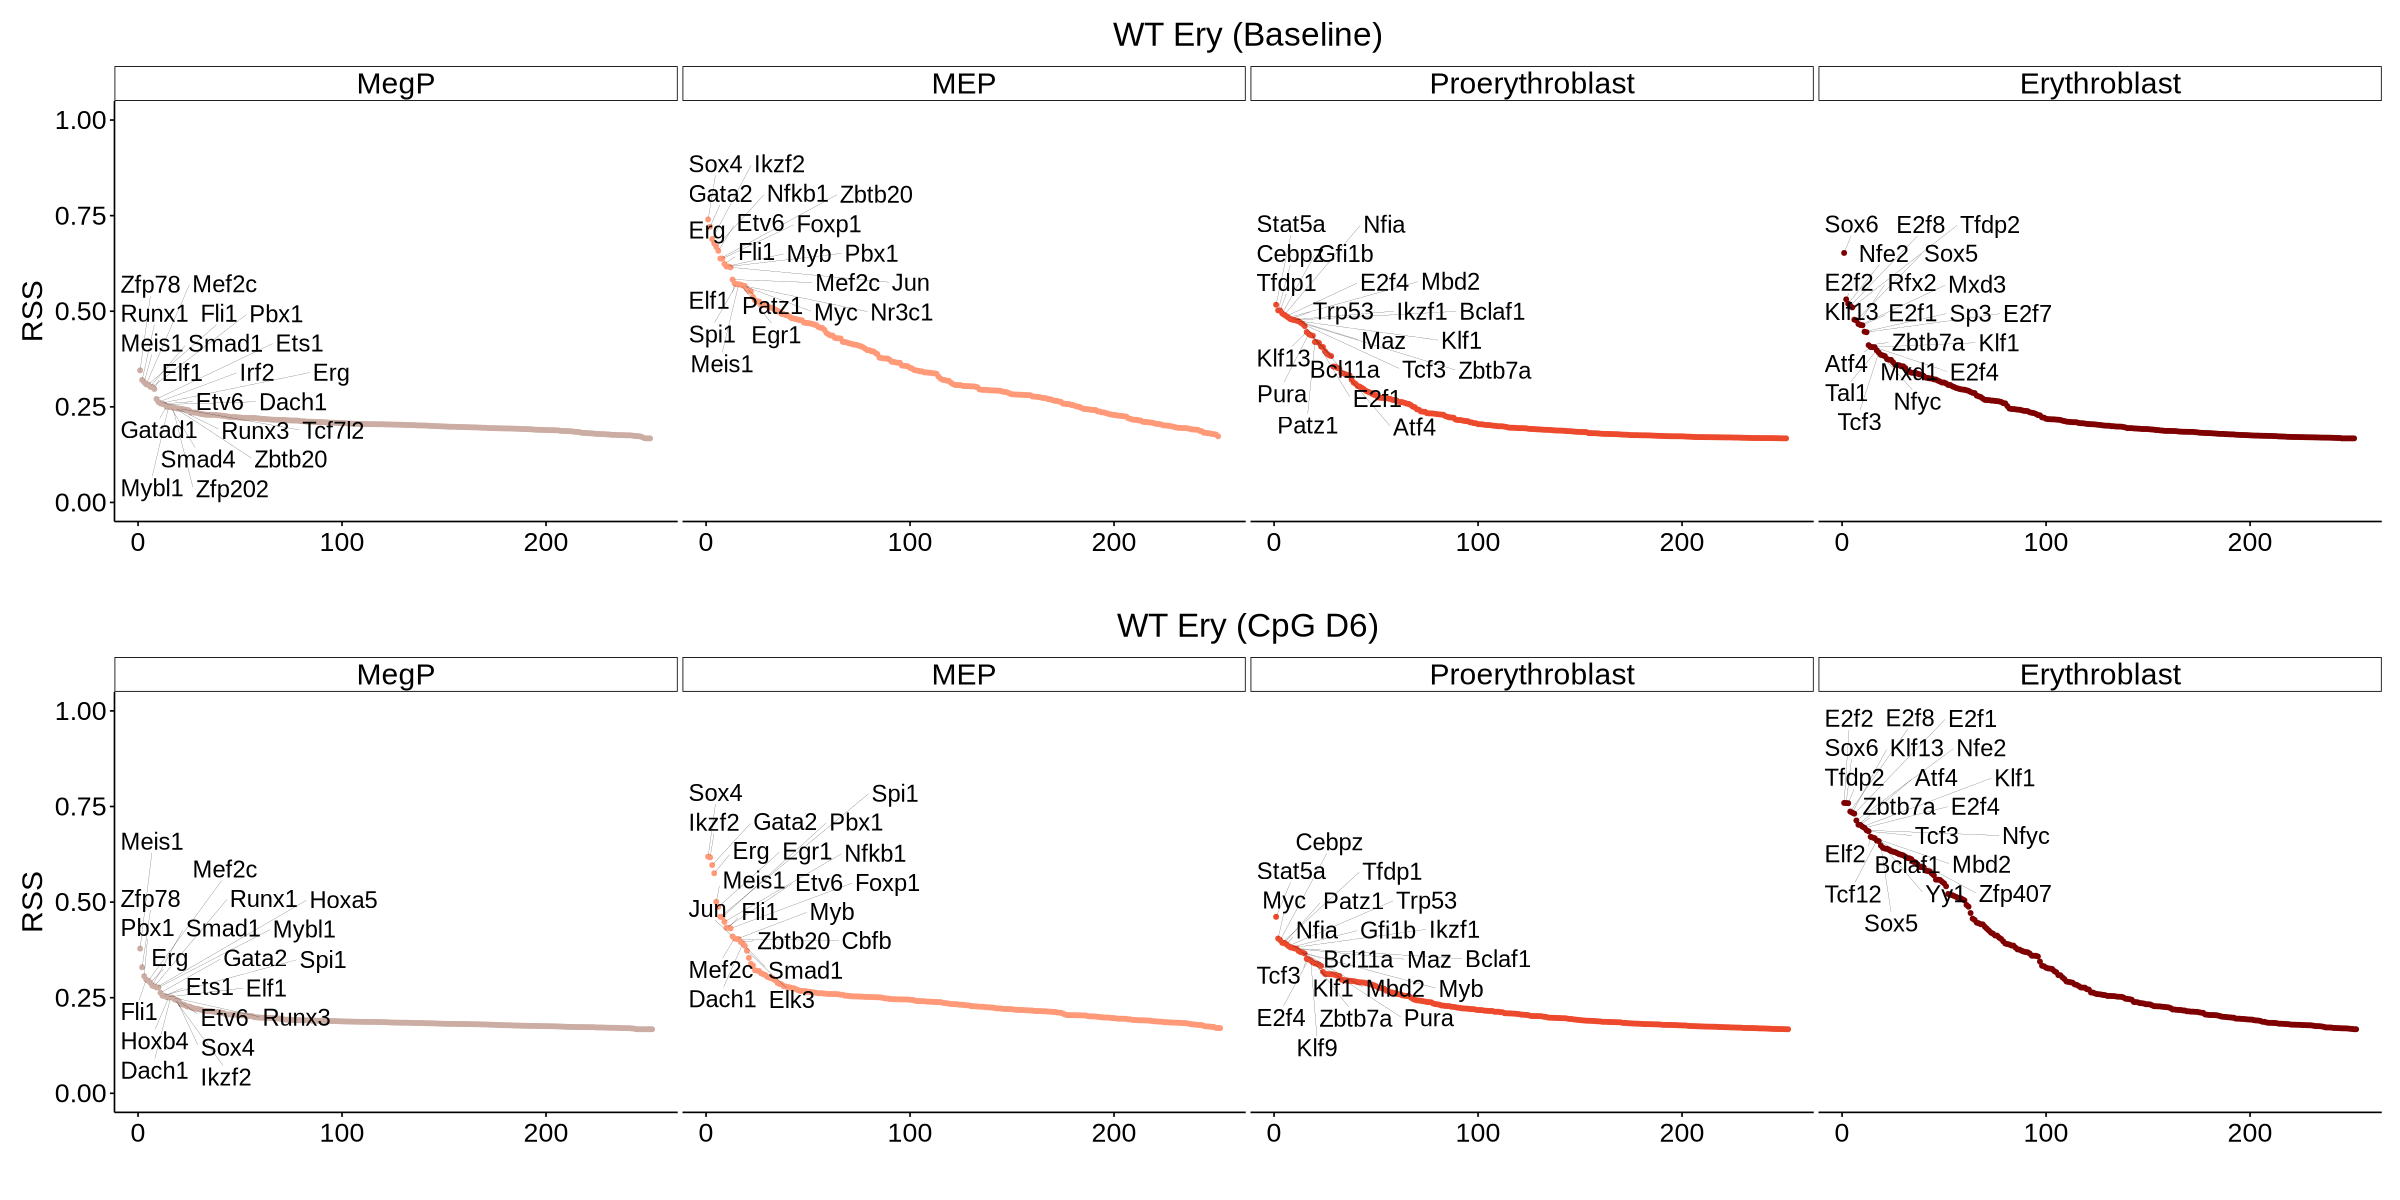

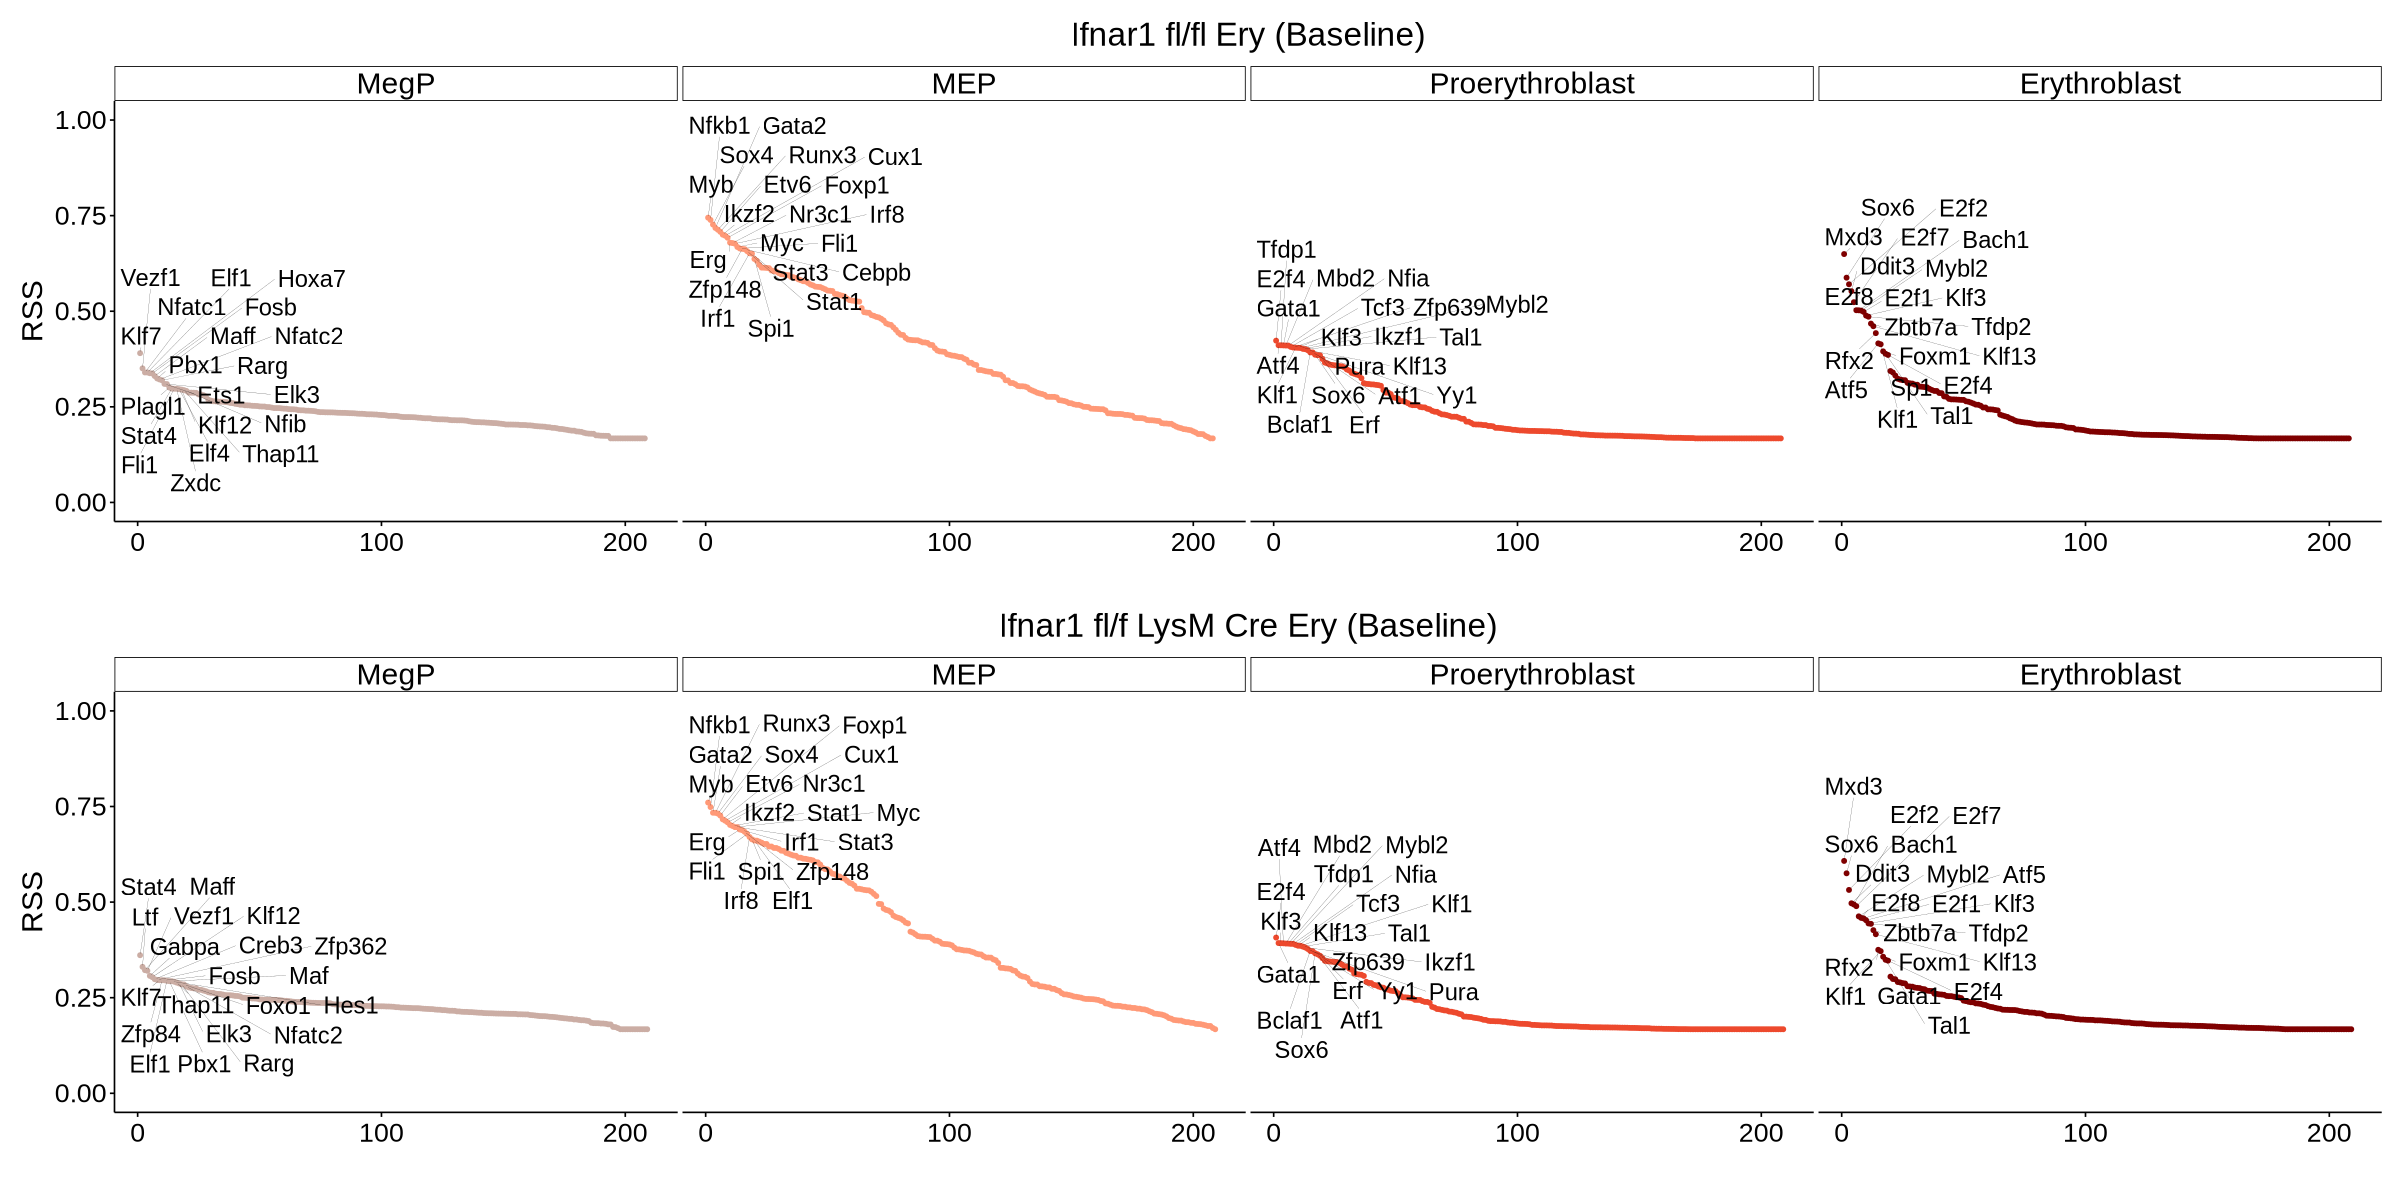

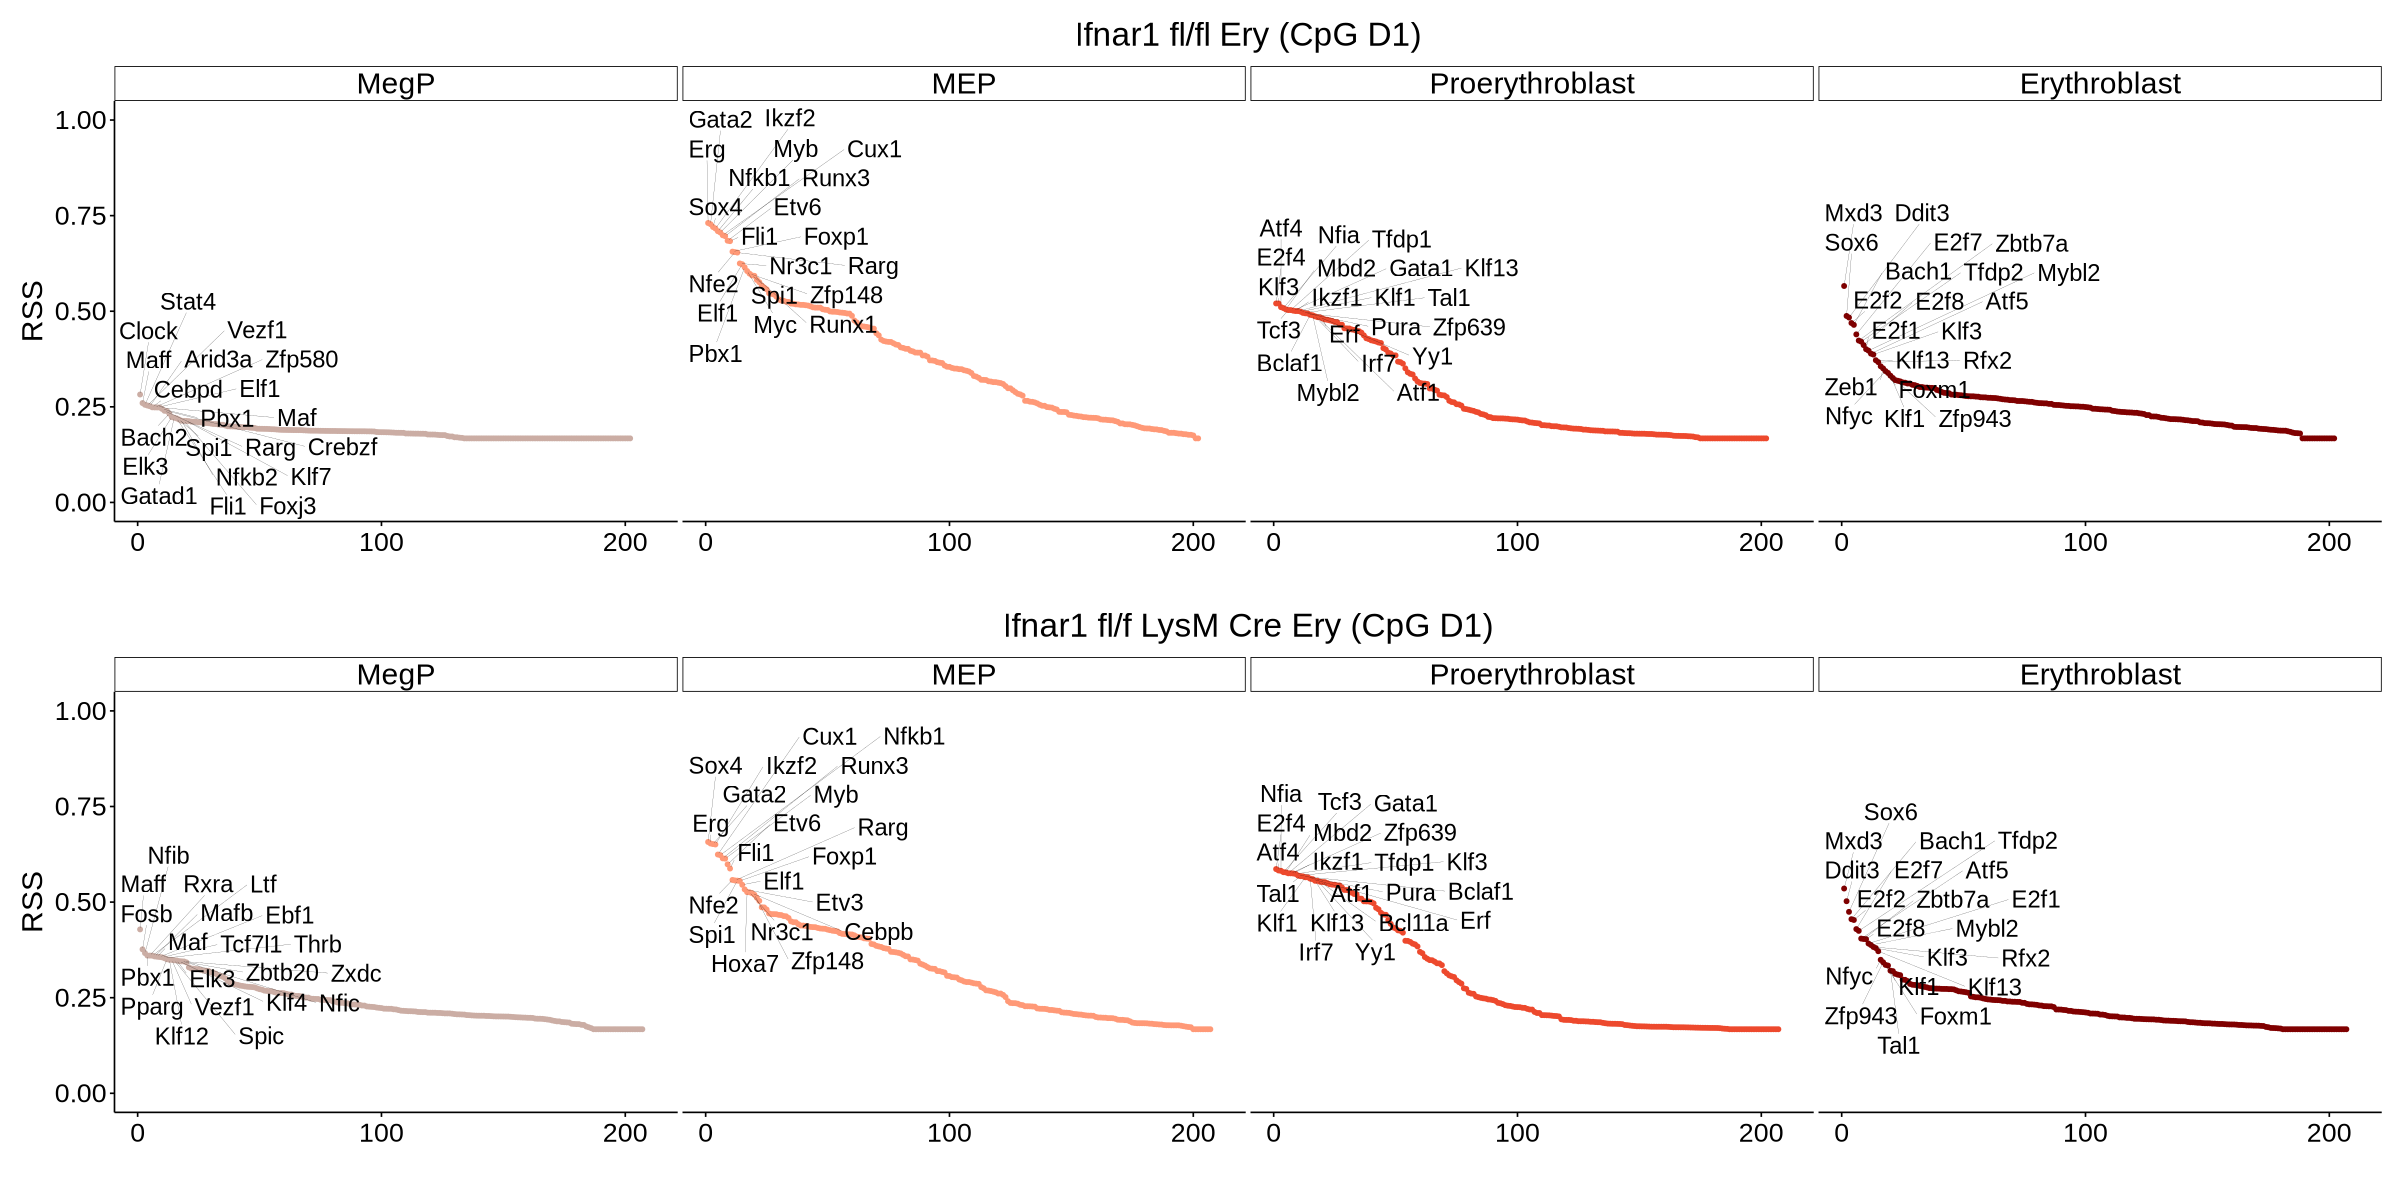

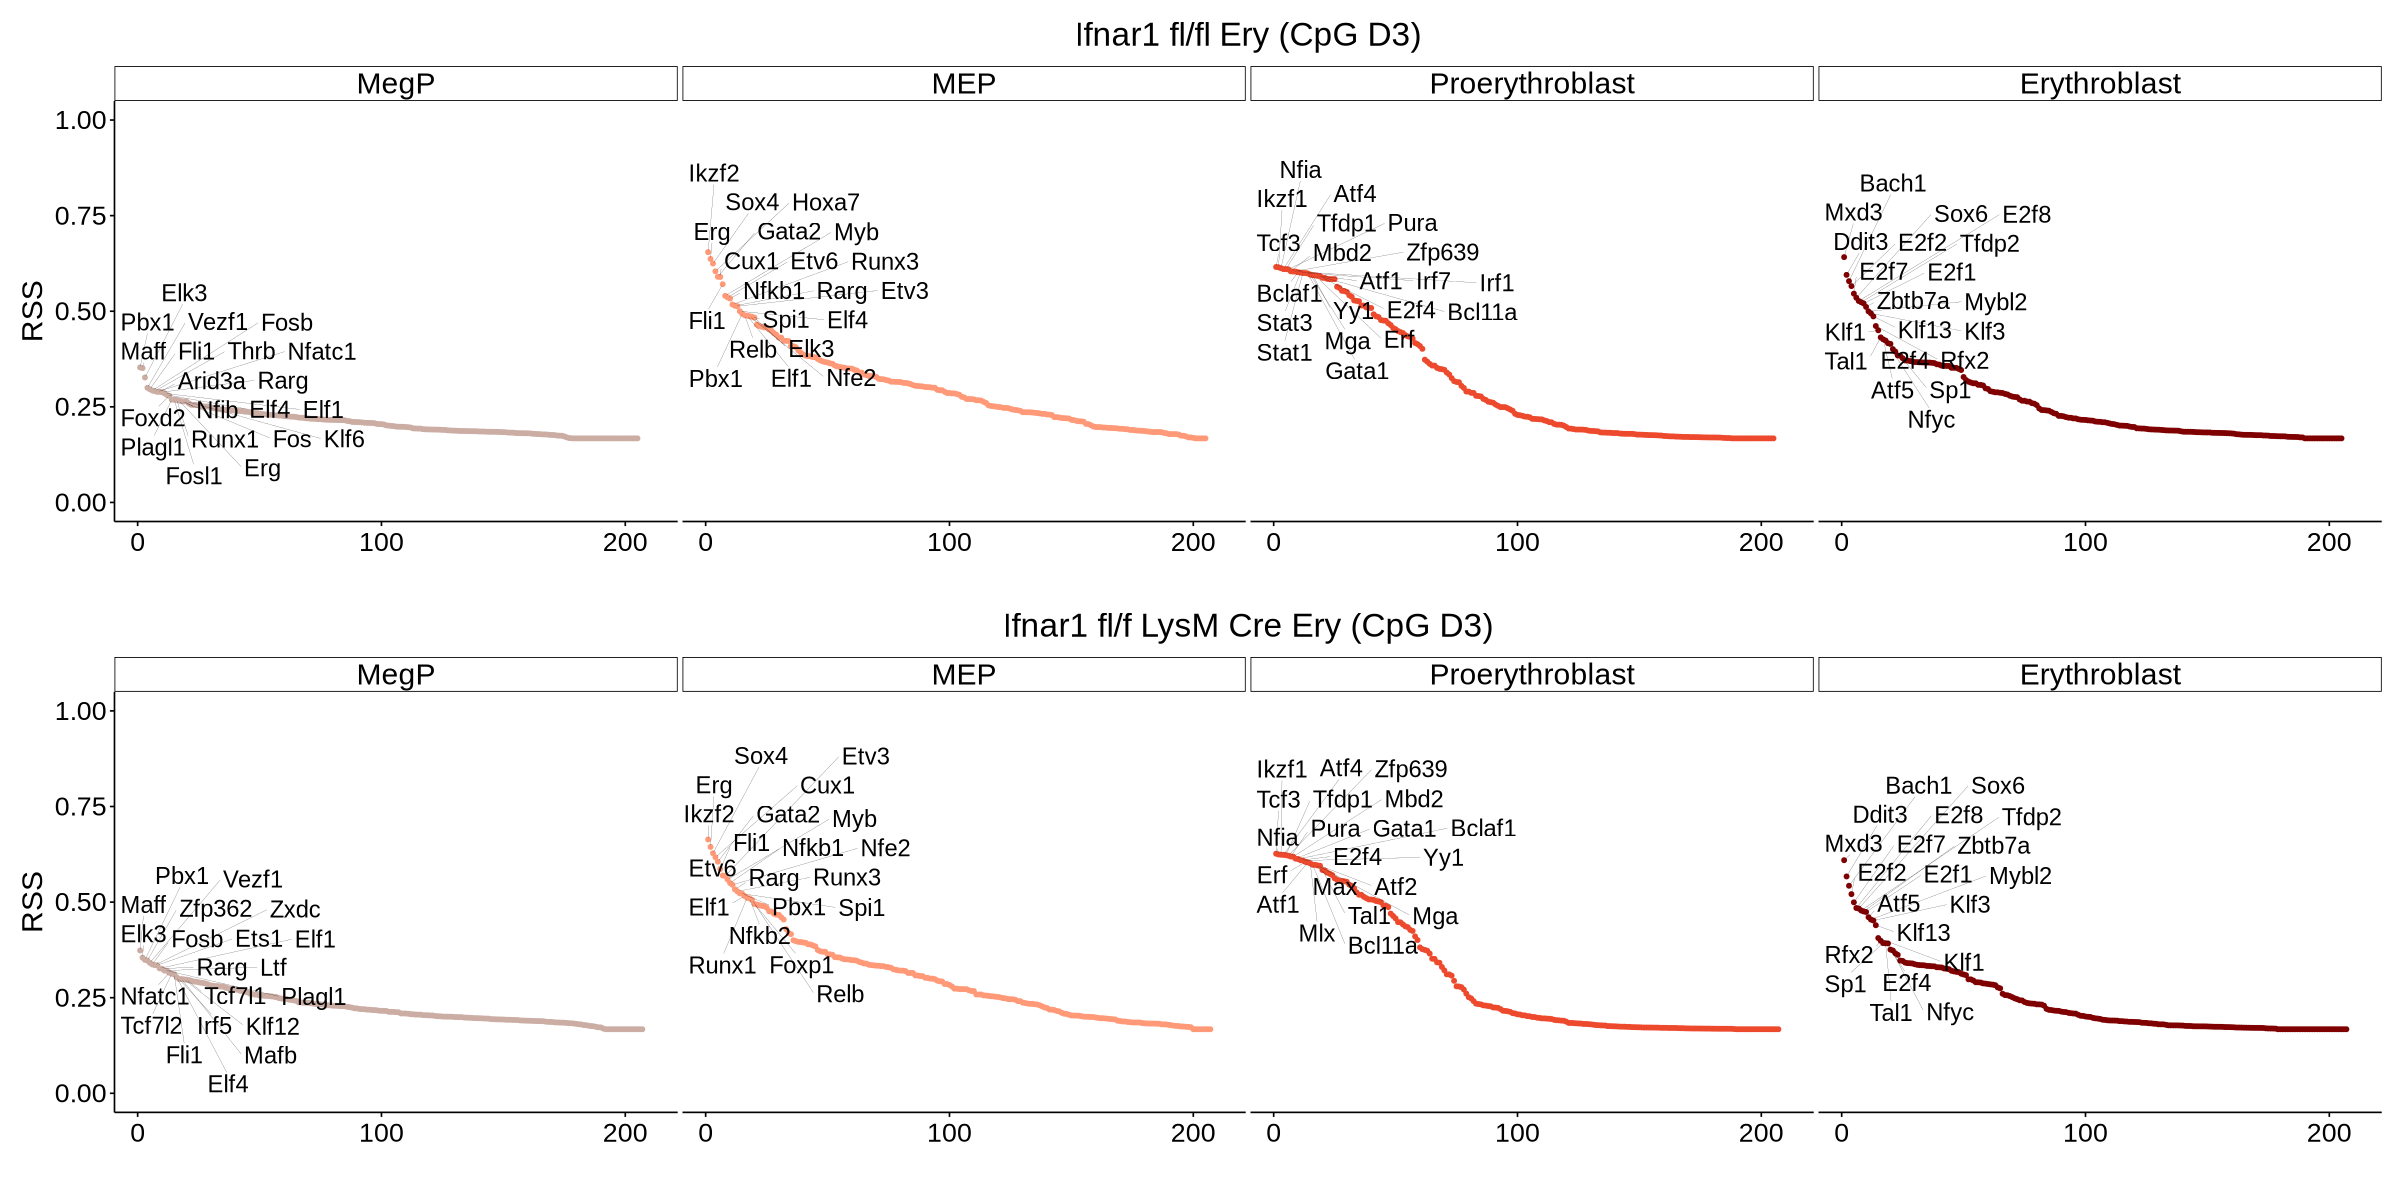

In [27]:
options(repr.plot.width=20, repr.plot.height=10)

rss_plot(mat_1, "WT Ery (Baseline)") + rss_plot(mat_2, "WT Ery (CpG D6)") + patchwork::plot_layout(ncol=1)

rss_plot(mat_3, "Ifnar1 fl/fl Ery (Baseline)") + rss_plot(mat_6, "Ifnar1 fl/f LysM Cre Ery (Baseline)") + patchwork::plot_layout(ncol=1)
rss_plot(mat_4, "Ifnar1 fl/fl Ery (CpG D1)") + rss_plot(mat_7, "Ifnar1 fl/f LysM Cre Ery (CpG D1)") + patchwork::plot_layout(ncol=1)
rss_plot(mat_5, "Ifnar1 fl/fl Ery (CpG D3)") + rss_plot(mat_8, "Ifnar1 fl/f LysM Cre Ery (CpG D3)") + patchwork::plot_layout(ncol=1)

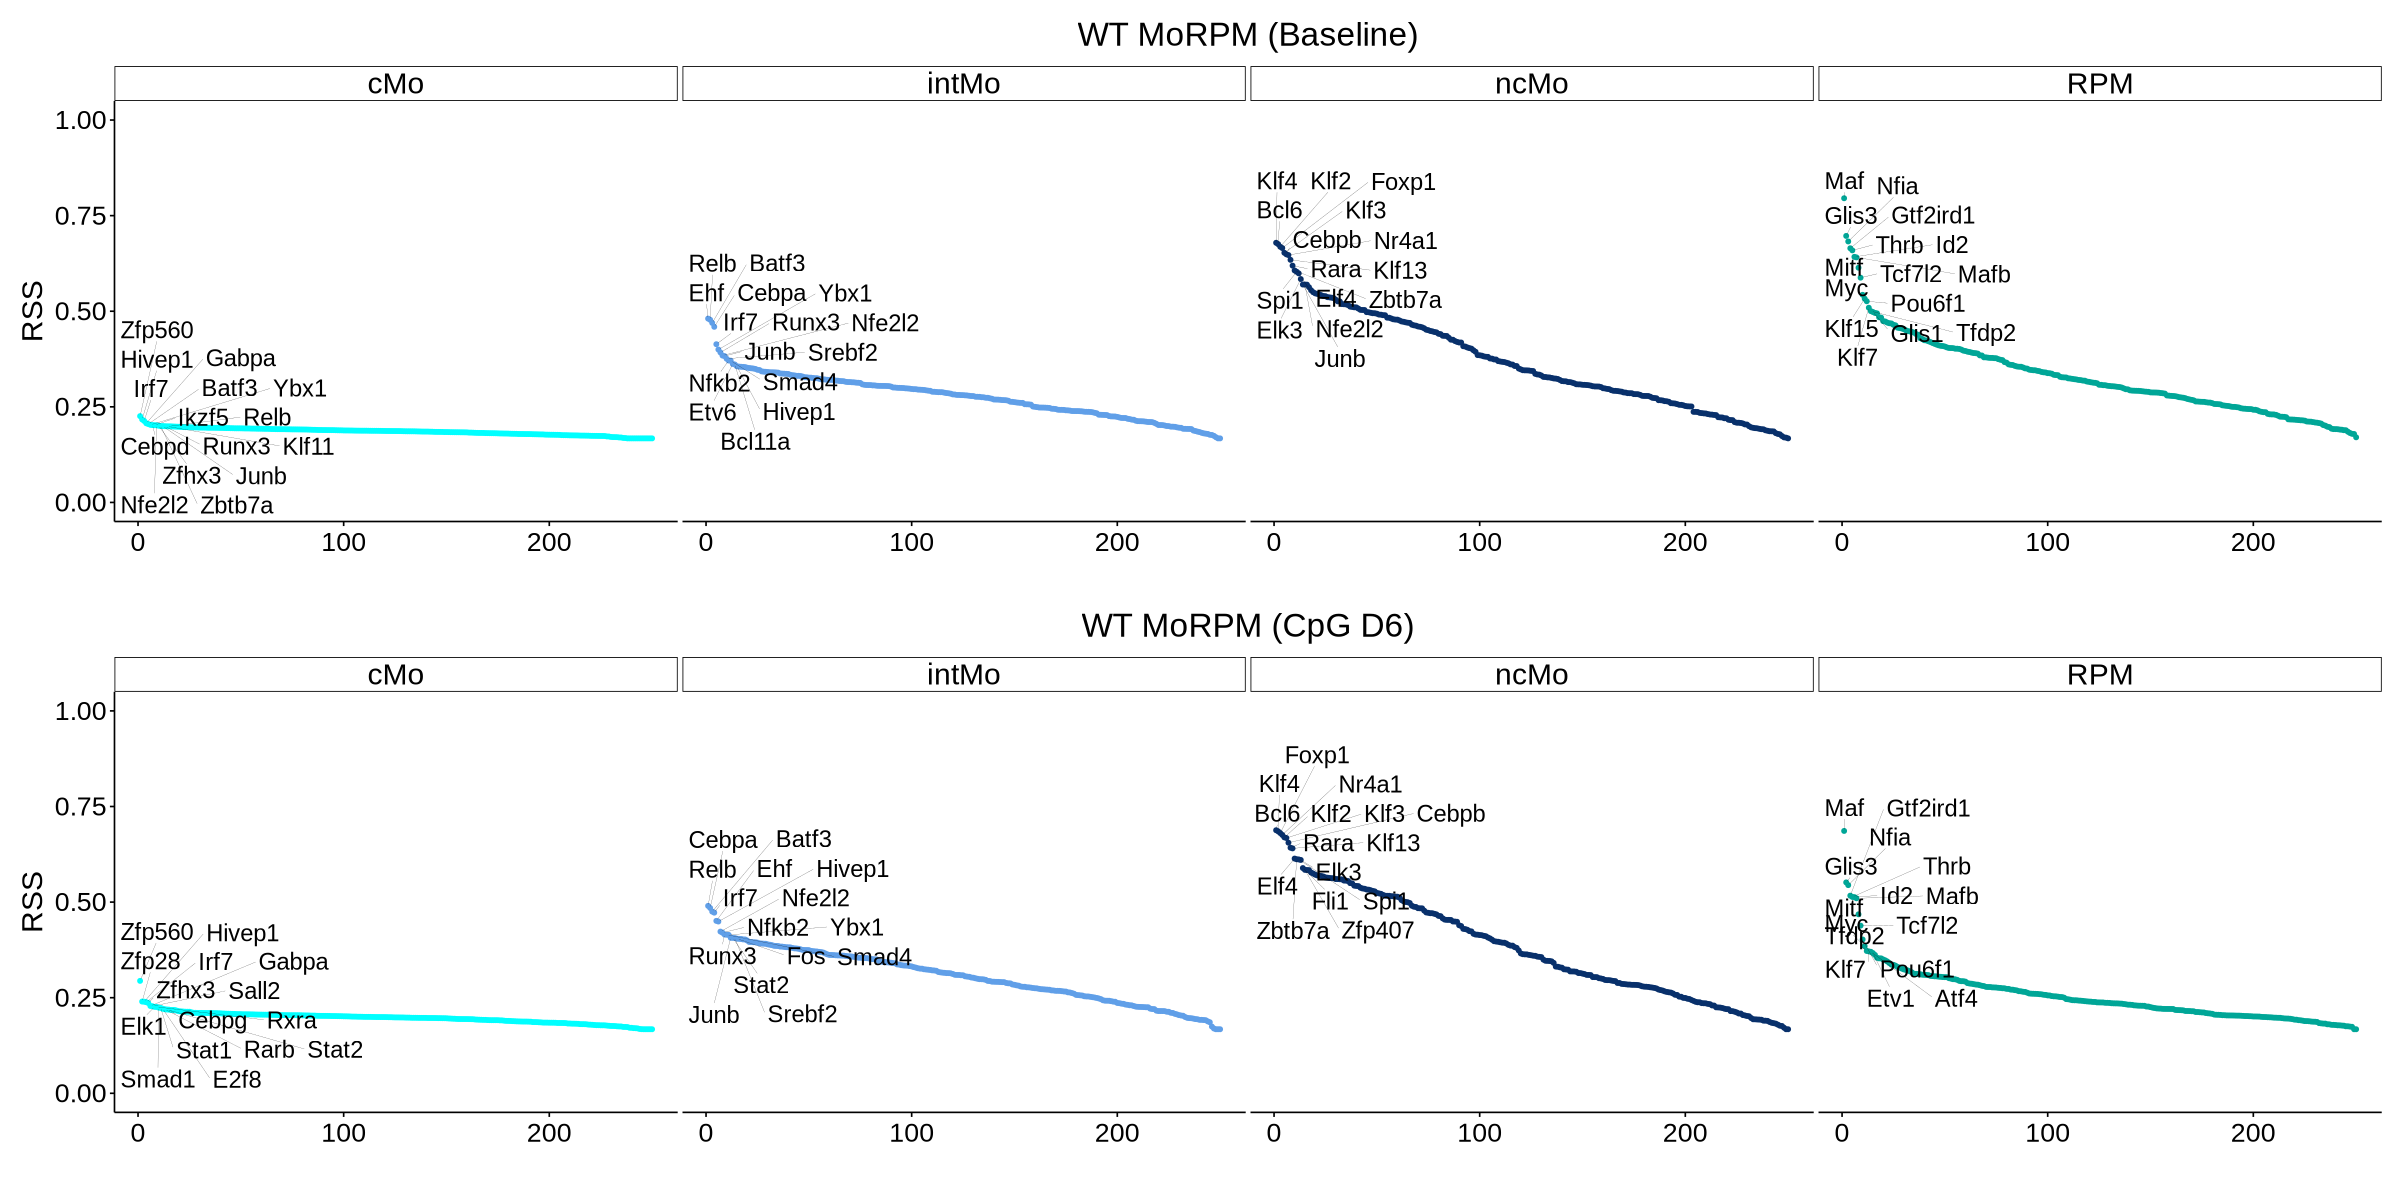

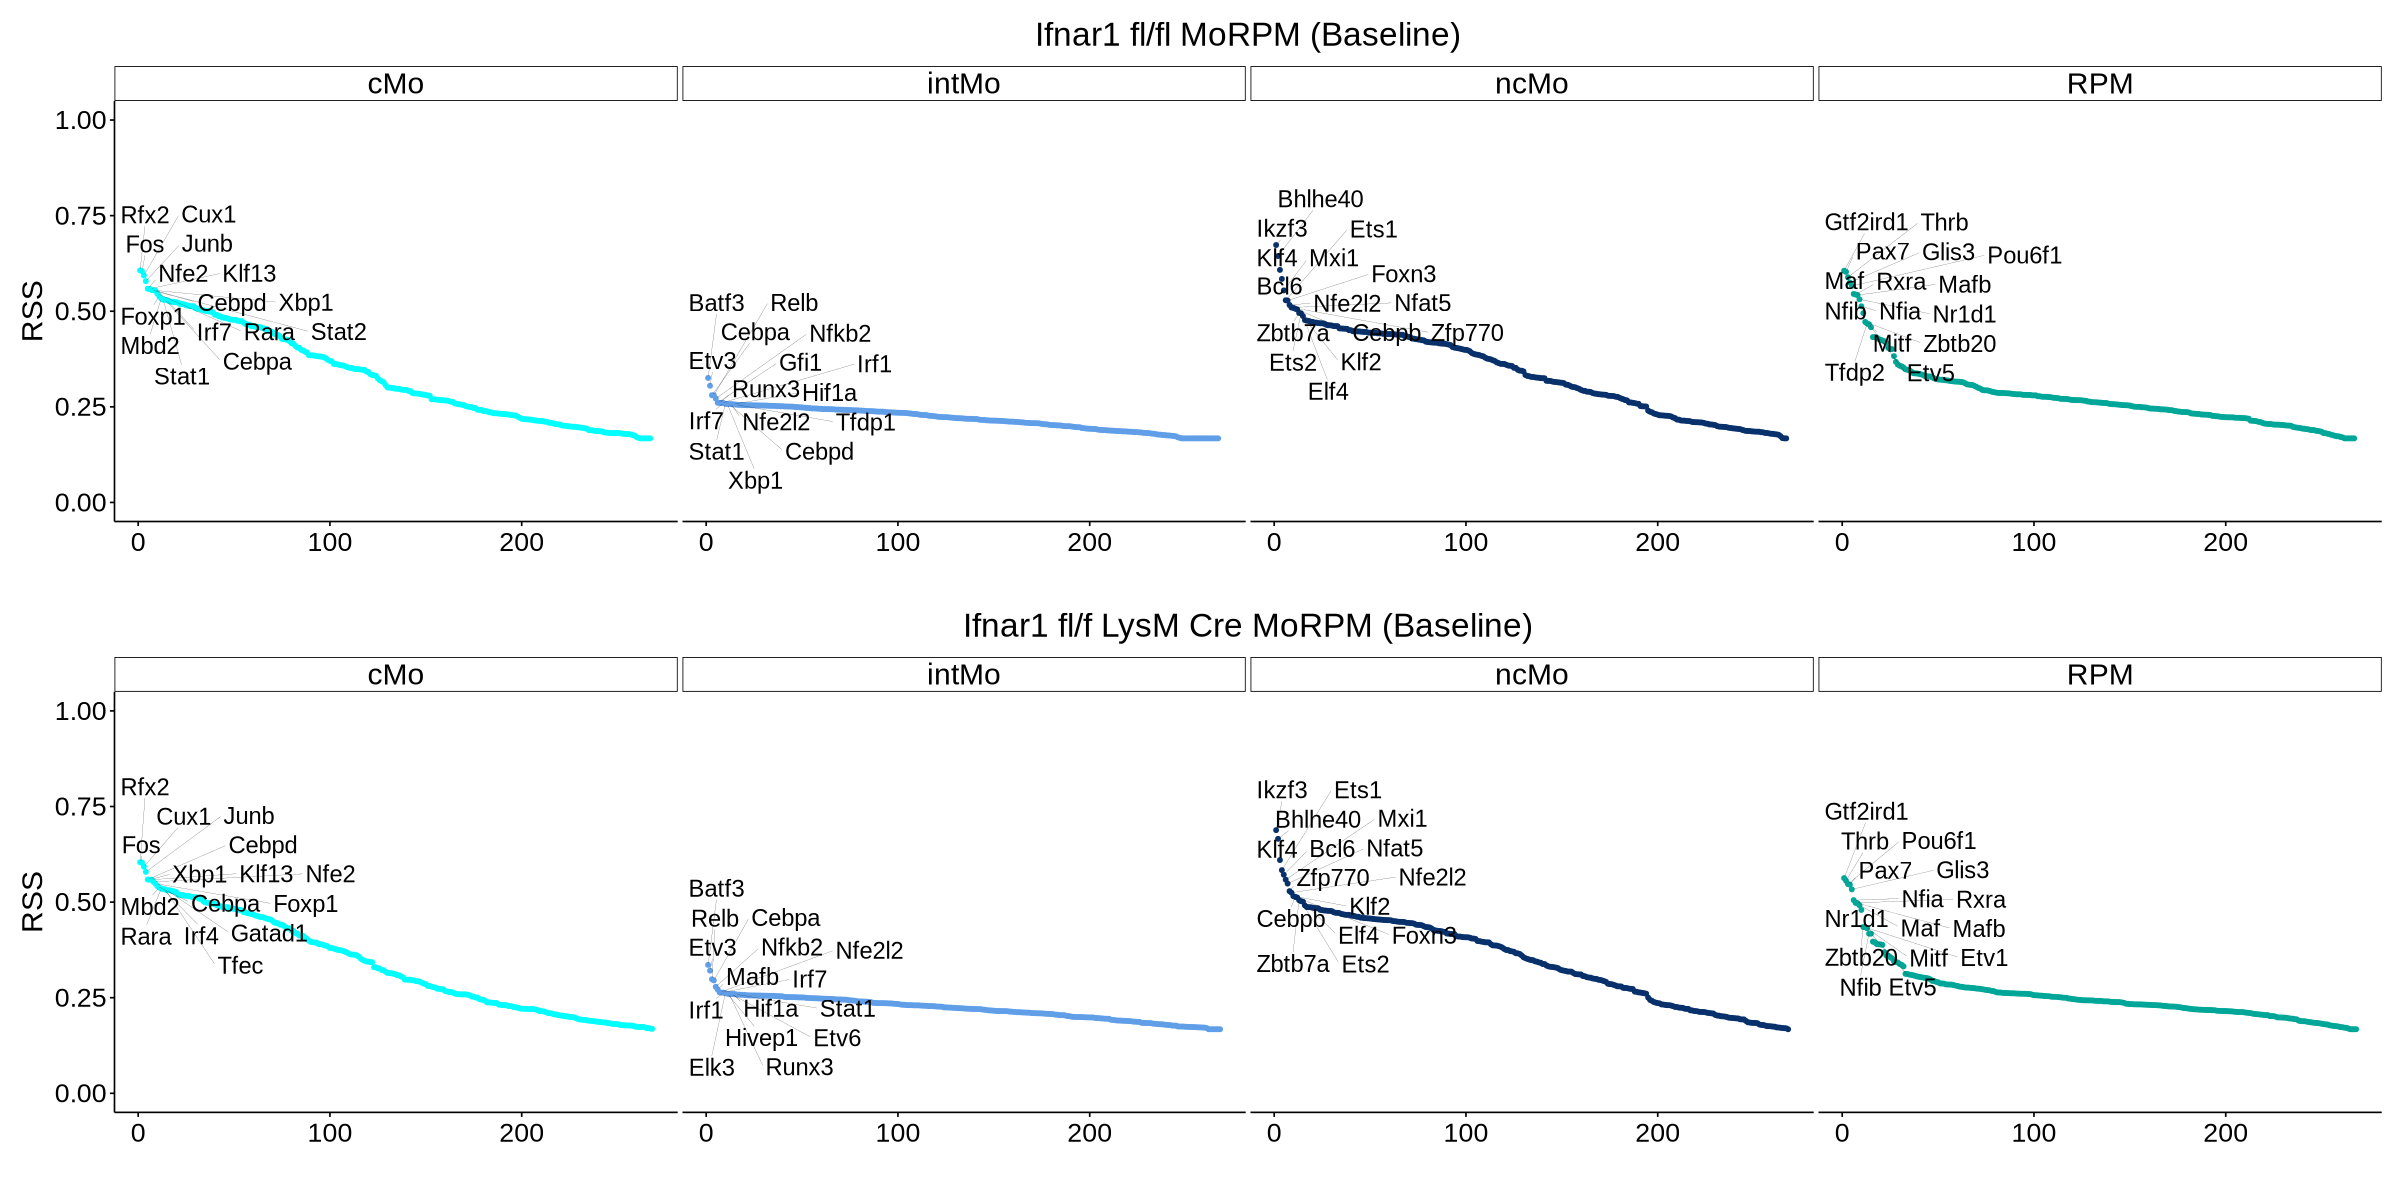

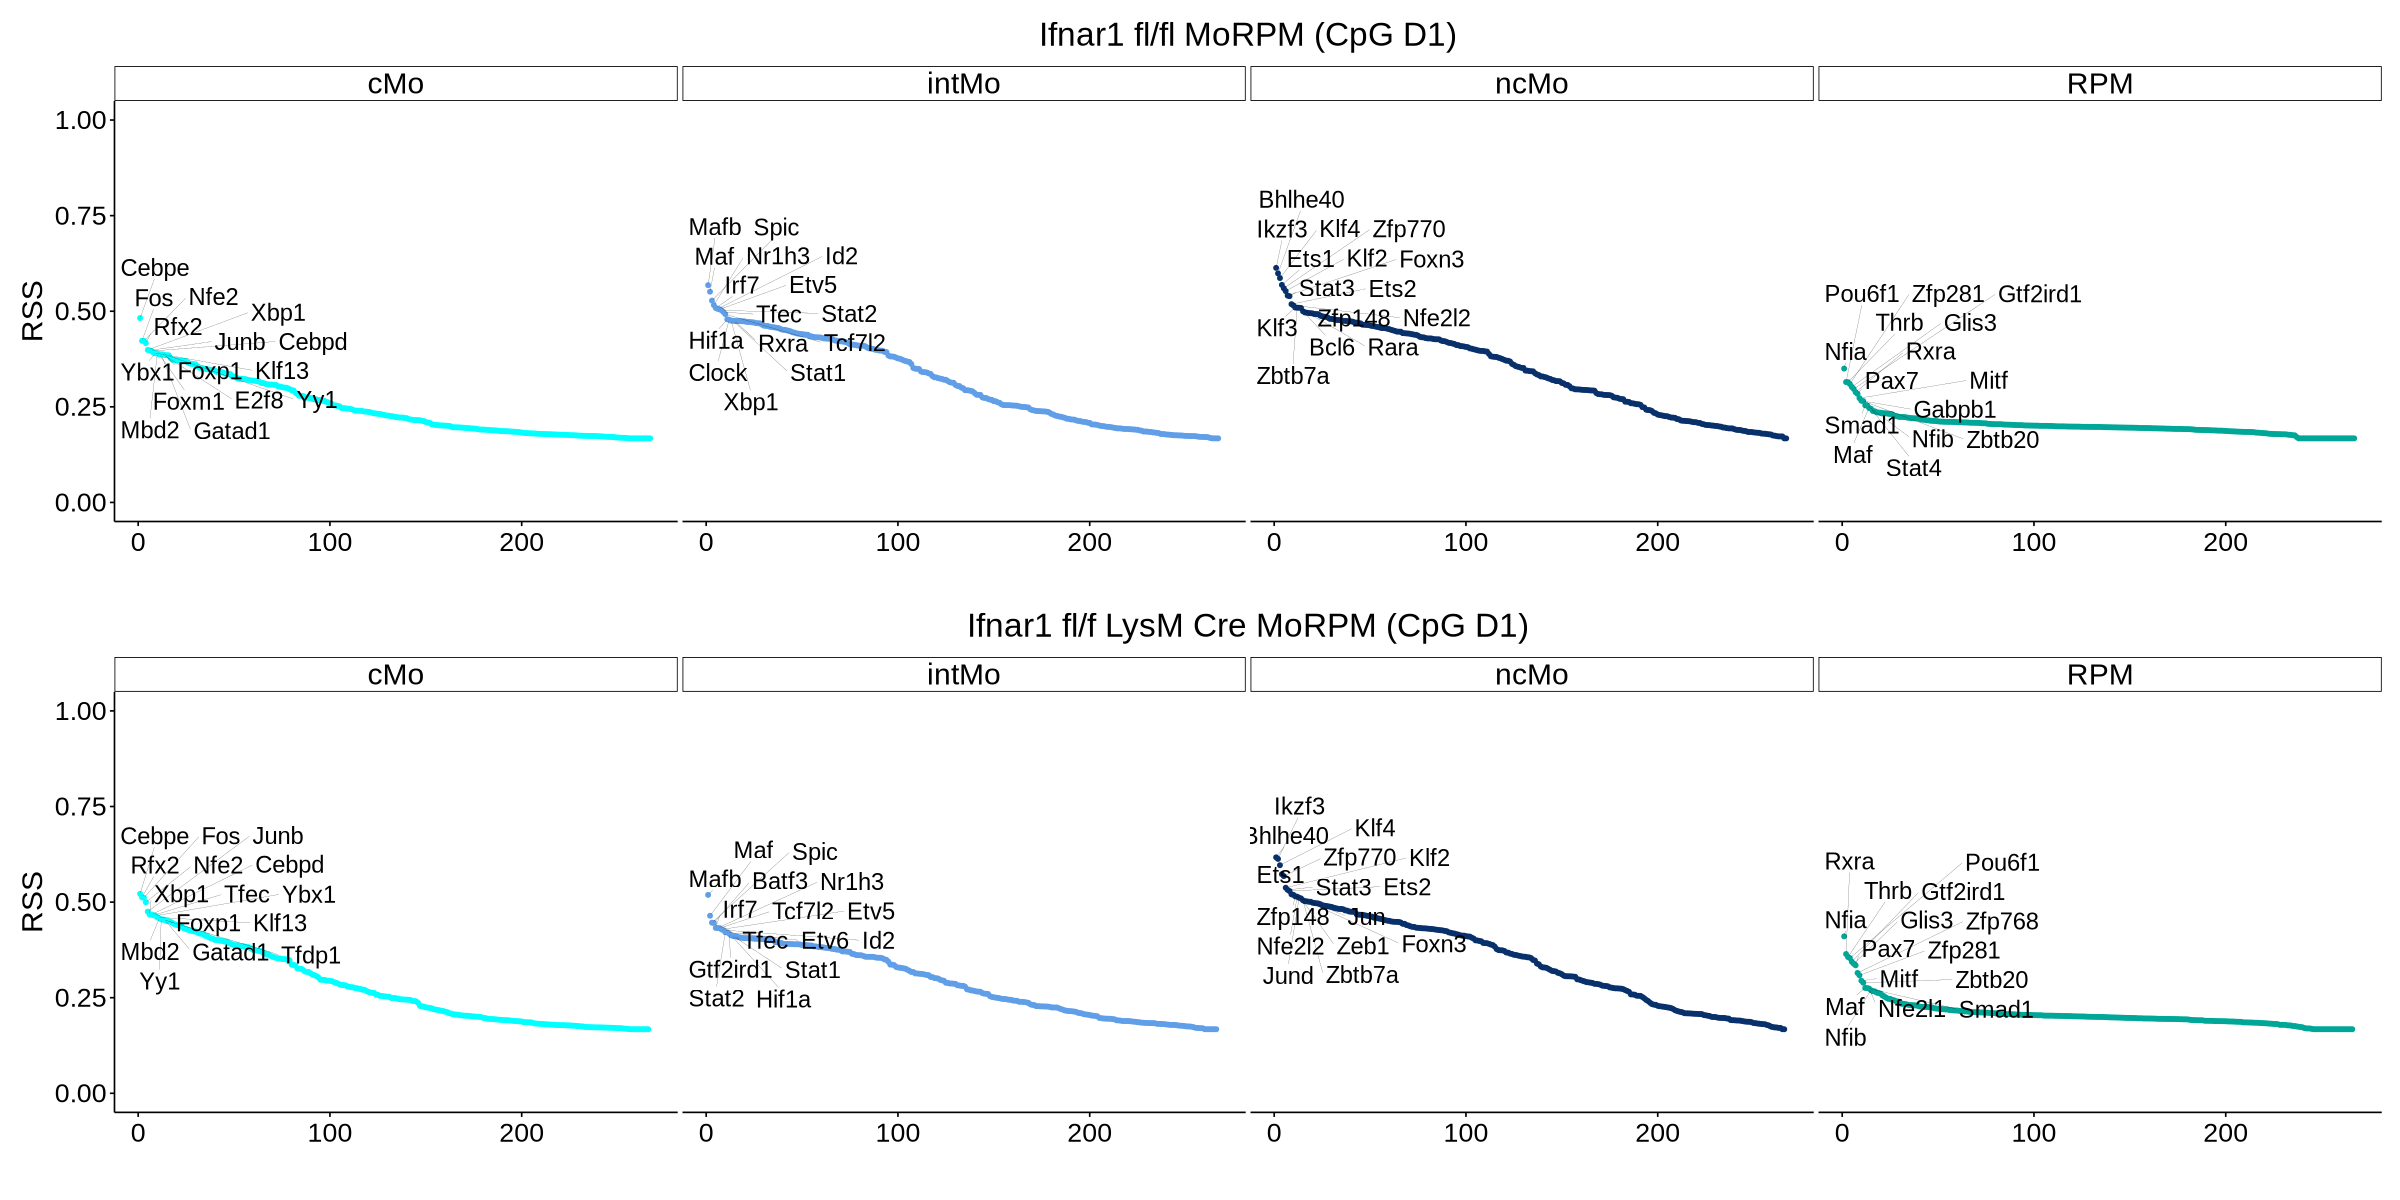

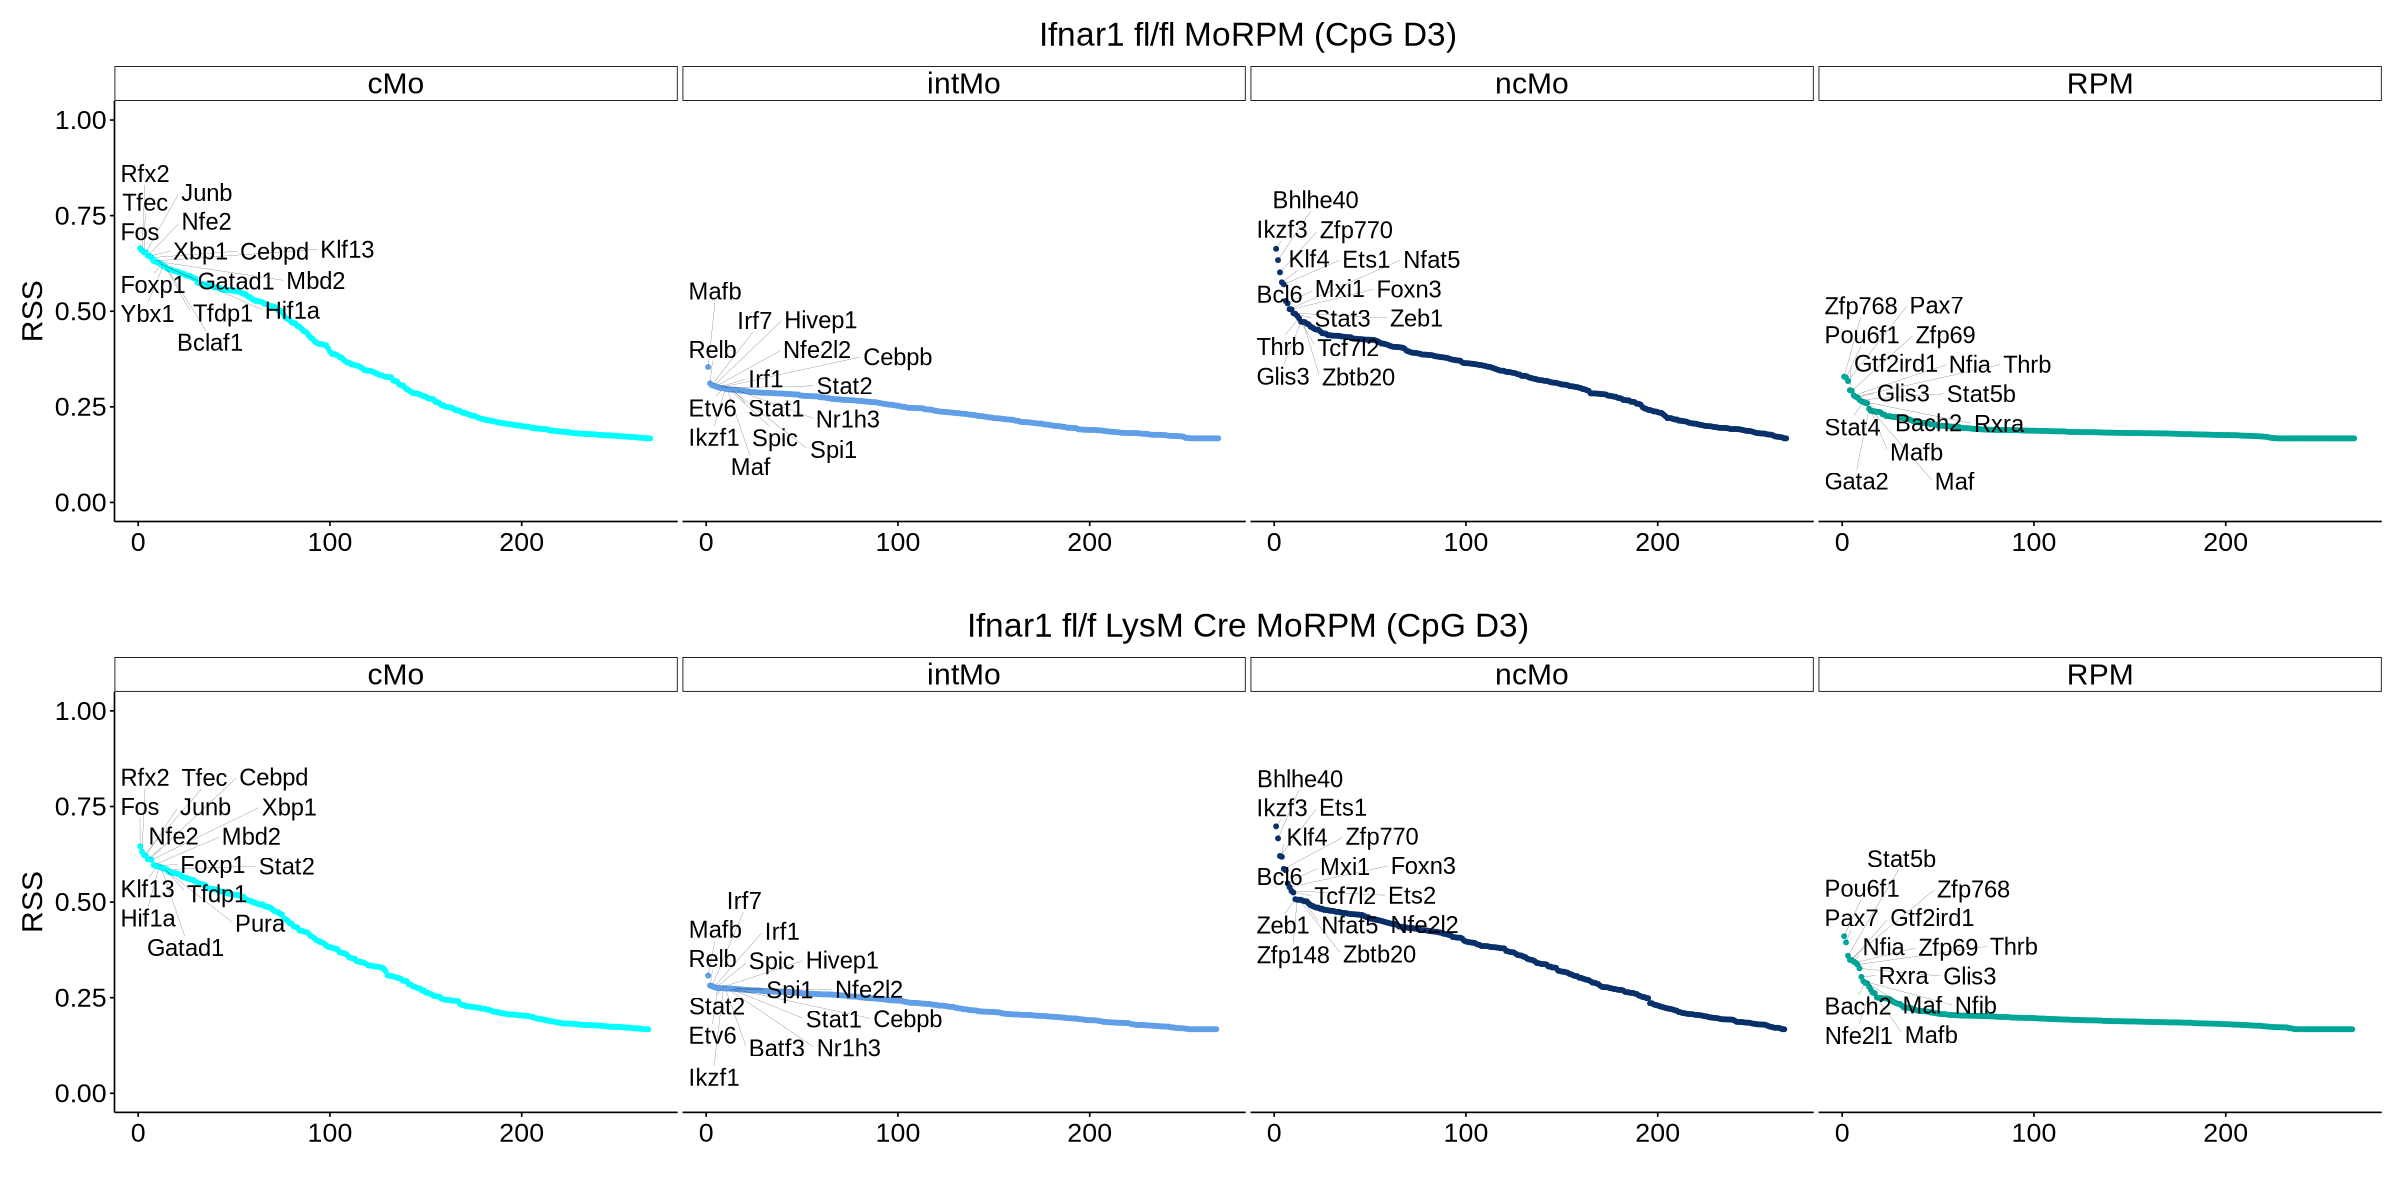

In [18]:
rss_plot(mat_9, "WT MoRPM (Baseline)") + rss_plot(mat_10, "WT MoRPM (CpG D6)") + patchwork::plot_layout(ncol=1)

rss_plot(mat_11, "Ifnar1 fl/fl MoRPM (Baseline)") + rss_plot(mat_14, "Ifnar1 fl/f LysM Cre MoRPM (Baseline)") + patchwork::plot_layout(ncol=1)
rss_plot(mat_12, "Ifnar1 fl/fl MoRPM (CpG D1)") + rss_plot(mat_15, "Ifnar1 fl/f LysM Cre MoRPM (CpG D1)") + patchwork::plot_layout(ncol=1)
rss_plot(mat_13, "Ifnar1 fl/fl MoRPM (CpG D3)") + rss_plot(mat_16, "Ifnar1 fl/f LysM Cre MoRPM (CpG D3)") + patchwork::plot_layout(ncol=1)

# AUC Wilcoxon  

In [19]:
wilcox <- function(so, ident, ident_1=NULL, ident_2=NULL, only_pos=FALSE, avg_log2FC_threshold=0, min_pct=0, test_use="wilcox", assay="RNA", slot="data") {
    
    # Drop empty levels 
    so@meta.data <- droplevels(so@meta.data)
    
    # Check number of cells 
    n_cells_1 <- sum(so@meta.data[[ident]]==ident_1)
    n_cells_2 <- sum(so@meta.data[[ident]]==ident_2)

    check_1 <- n_cells_1 >= 3
    check_2 <- n_cells_2 >= 3
    
    if(check_1 & check_2) {
        
        so <- SetIdent(so, value=ident)
        res <- RunPresto(so, ident.1=ident_1, ident.2=ident_2, logfc.threshold=avg_log2FC_threshold, min.pct=min_pct, only.pos=only_pos, test.use=test_use, assay=assay, slot=slot)
        
        # Annotate results 
        res$gene <- rownames(res)

        # N cells per group 
        res$n_cells_1 <- n_cells_1
        res$n_cells_2 <- n_cells_2

        # Cell type 
        res$celltype_low <- so$celltype_low[1]

        return(res)
        
    } else {
        
        return(NULL)
        
    }
        


}

# Erythroid BSF comparison 

In [20]:
# Set group variable
so_0$group <- so_0$sample_group

In [21]:
# Prepare data 
so_0 <- SplitObject(so_0, split.by="celltype_low")

## WT Baseline vs WT CpG D6

In [22]:
contrasts_vec <- c("Bl6_CpG_D6", "Bl6_NaCl_D6")

In [23]:
so_res <- so_0
so_res <- lapply(so_res, function(x) subset(x, subset=group %in% contrasts_vec))
so_res <- so_res[!lapply(so_res, is.null) %>% unlist()]

In [24]:
res_0 <- lapply(so_res, function(so) {wilcox(
    
    so=so, 
    ident="group", 
    ident_1=contrasts_vec[1], 
    ident_2=contrasts_vec[2], 
    only_pos=FALSE, 
    avg_log2FC_threshold=0, 
    min_pct=0, 
    assay="AUC", 
    slot="data", 
    test_use="wilcox"
    
)
                                  }
               )

In [26]:
res_0 <- lapply(names(res_0), function(i) {

    res <- res_0[[i]] %>% dplyr::rename(module=gene)

    rss <- dplyr::inner_join(
        
        mat_2[mat_2$celltype_low==i, c("module", "rss", "rank")] %>% dplyr::rename(rss_1=rss, rank_1=rank), 
        mat_1[mat_1$celltype_low==i, c("module", "rss", "rank")] %>% dplyr::rename(rss_2=rss, rank_2=rank), 
        by=join_by(module)
    
    )

    res <- dplyr::left_join(res, rss, by=join_by(module))

    rownames(res) <- res$module

    return(res)
    
}
              )

In [27]:
names(res_0) <- lapply(res_0, function(x) x$celltype_low[1]) %>% unlist()

In [28]:
names(res_0) <- make.names(names(res_0))
saveRDS(res_0, paste0("result/scenic/scRNAseq/", "auc_wilcox_ery_", tolower(contrasts_vec[1]), "_vs_", tolower(contrasts_vec[2]), ".rds"))

# Myeloid BSF comparison 

In [29]:
# Set group variable
so_2$group <- so_2$sample_group

In [30]:
# Prepare data 
so_2 <- SplitObject(so_2, split.by="celltype_low")

## WT Baseline vs WT CpG D6

In [31]:
contrasts_vec <- c("Bl6_CpG_D6", "Bl6_NaCl_D6")

In [32]:
so_res <- so_2
so_res <- lapply(so_res, function(x) subset(x, subset=group %in% contrasts_vec))
so_res <- so_res[!lapply(so_res, is.null) %>% unlist()]

In [33]:
res_2 <- lapply(so_res, function(so) {wilcox(
    
    so=so, 
    ident="group", 
    ident_1=contrasts_vec[1], 
    ident_2=contrasts_vec[2], 
    only_pos=FALSE, 
    avg_log2FC_threshold=0, 
    min_pct=0, 
    assay="AUC", 
    slot="data", 
    test_use="wilcox"
    
)
                                  }
               )

In [34]:
res_2 <- lapply(names(res_2), function(i) {

    res <- res_2[[i]] %>% dplyr::rename(module=gene)

    rss <- dplyr::inner_join(
        
        mat_2[mat_2$celltype_low==i, c("module", "rss", "rank")] %>% dplyr::rename(rss_1=rss, rank_1=rank), 
        mat_1[mat_1$celltype_low==i, c("module", "rss", "rank")] %>% dplyr::rename(rss_2=rss, rank_2=rank), 
        by=join_by(module)
    
    )

    res <- dplyr::left_join(res, rss, by=join_by(module))

    rownames(res) <- res$module

    return(res)
    
}
              )

In [35]:
names(res_2) <- lapply(res_2, function(x) x$celltype_low[1]) %>% unlist()

In [36]:
names(res_2) <- make.names(names(res_2))
saveRDS(res_2, paste0("result/scenic/scRNAseq/", "auc_wilcox_myeloid_", tolower(contrasts_vec[1]), "_vs_", tolower(contrasts_vec[2]), ".rds"))

# Myeloid VBC comparison 

In [37]:
# Set group variable
so_3$group <- so_3$sample_group

In [38]:
# Prepare data 
so_3 <- SplitObject(so_3, split.by="celltype_low")

## Ifnar fl/fl D0 vs Ifnar fl/fl D1

In [39]:
contrasts_vec <- c("IFNAR_fl_CpG_D1", "IFNAR_fl_Baseline_D0")

In [40]:
so_res <- so_3
so_res <- lapply(so_res, function(x) subset(x, subset=group %in% contrasts_vec))
so_res <- so_res[!lapply(so_res, is.null) %>% unlist()]

In [41]:
res_3_0 <- lapply(so_res, function(so) {wilcox(
    
    so=so, 
    ident="group", 
    ident_1=contrasts_vec[1], 
    ident_2=contrasts_vec[2], 
    only_pos=FALSE, 
    avg_log2FC_threshold=0, 
    min_pct=0, 
    assay="AUC", 
    slot="data", 
    test_use="wilcox"
    
)
                                  }
               )

In [42]:
res_3_0 <- lapply(names(res_3_0), function(i) {

    res <- res_3_0[[i]] %>% dplyr::rename(module=gene)

    rss <- dplyr::inner_join(
        
        mat_12[mat_12$celltype_low==i, c("module", "rss", "rank")] %>% dplyr::rename(rss_1=rss, rank_1=rank), 
        mat_11[mat_11$celltype_low==i, c("module", "rss", "rank")] %>% dplyr::rename(rss_2=rss, rank_2=rank), 
        by=join_by(module)
    
    )

    res <- dplyr::left_join(res, rss, by=join_by(module))

    rownames(res) <- res$module

    return(res)
    
}
              )

In [43]:
names(res_3_0) <- lapply(res_3_0, function(x) x$celltype_low[1]) %>% unlist()

In [44]:
names(res_3_0) <- make.names(names(res_3_0))
saveRDS(res_3_0, paste0("result/scenic/scRNAseq/", "auc_wilcox_ery_", tolower(contrasts_vec[1]), "_vs_", tolower(contrasts_vec[2]), ".rds"))

## Ifnar fl/fl D0 vs Ifnar fl/fl D3

In [45]:
contrasts_vec <- c("IFNAR_fl_CpG_D3", "IFNAR_fl_Baseline_D0")

In [46]:
so_res <- so_3
so_res <- lapply(so_res, function(x) subset(x, subset=group %in% contrasts_vec))
so_res <- so_res[!lapply(so_res, is.null) %>% unlist()]

In [47]:
res_3_1 <- lapply(so_res, function(so) {wilcox(
    
    so=so, 
    ident="group", 
    ident_1=contrasts_vec[1], 
    ident_2=contrasts_vec[2], 
    only_pos=FALSE, 
    avg_log2FC_threshold=0, 
    min_pct=0, 
    assay="AUC", 
    slot="data", 
    test_use="wilcox"
    
)
                                  }
               )

In [48]:
res_3_1 <- lapply(names(res_3_1), function(i) {

    res <- res_3_1[[i]] %>% dplyr::rename(module=gene)

    rss <- dplyr::inner_join(
        
        mat_13[mat_13$celltype_low==i, c("module", "rss", "rank")] %>% dplyr::rename(rss_1=rss, rank_1=rank), 
        mat_11[mat_11$celltype_low==i, c("module", "rss", "rank")] %>% dplyr::rename(rss_2=rss, rank_2=rank), 
        by=join_by(module)
    
    )

    res <- dplyr::left_join(res, rss, by=join_by(module))

    rownames(res) <- res$module

    return(res)
    
}
              )

In [49]:
names(res_3_1) <- lapply(res_3_1, function(x) x$celltype_low[1]) %>% unlist()

In [50]:
names(res_3_1) <- make.names(names(res_3_1))
saveRDS(res_3_1, paste0("result/scenic/scRNAseq/", "auc_wilcox_ery_", tolower(contrasts_vec[1]), "_vs_", tolower(contrasts_vec[2]), ".rds"))